# **I. Intro**

Hello, in this notebook I will try to explain the basic concepts and architecture of a Multi-Layered Perceptron, if you havent heard of it, it's just a basic multi layer feedforward ANN. If you want to start learning DL, I think this is a good point to start from, just think of this as a lab session in your journey understanding Deep Learning. Feel free to fork, tinker, and optimize this (gosh there're lots of fors and ifs here). I will focus on the MLP algorithm, hence I will just do some simple preprocessing and cleaning. Also in case you're looking for a way to improve your score in this dataset, this is not the one as this code is relatively simple. 

First, we load both the training and testing data + look if there's any NaNs/empty cells. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
data=pd.read_csv('/kaggle/input/titanic/train.csv')
testdata=pd.read_csv('/kaggle/input/titanic/test.csv')
print(data.head())#print first 5 rows
print("Training")
print(data.dtypes)#print each column's datatype
print("Testing")
print(testdata.dtypes)
print("Training")
for column in data.columns:#print the number of NaN values in each column
    print(column,":",data.shape[0]-data[column].count())
print("\nTesting")
for column in testdata.columns:#print the number of NaN values in each column
    print(column,":",testdata.shape[0]-testdata[column].count())

# **II. Data Cleaning**

We can see from the result above that we have lots of NaNs for "Age" and "Cabin" for both sets of data + some in "Embarked" and "Fare" columns. To handle this data incompleteness, I will use the average age for each name title category. To do this, I:

1. Apply a lambda function to split a person's name using space as a delimiter, and then store the second word (index 1), which contains their title (e.g. Mr. Miss. etc) in a new "Title" column.

2. Store the mean of "Age", we will use this to fill the "Age" feature of those whose title has less than 10 members as those title categories that has very few members are prone to bias due to low sample size.

3. Plot the distribution of the first 5 Title categories to confirm our assumption (whether their title has anything to do with their age or not), as we can see some of the "Title" categories converges to certain value of "Age" (e.g. Miss tend to be younger than Mrs, Masters are usually very young etc). It's not pefect though, but then again we wont focus on this for now.

4. Fill the NaN values for those which "Title" category has more than 10 members with the mean of their "Title" category's Age. If not, fill it with the mean of the "Age" column that we have stored in step 2. We should fill this using the training data's value as in real scenario we wont know anything about the testing set.

5. Check if there's any NaN values left.

One column done, three to go!.



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#1. Extract the person's title and then store it to 'Title' column by splitting the string
#   and take the 2nd item.

data['Title']=data['Name'].apply(lambda x: x.split()[1])
testdata['Title']=data['Name'].apply(lambda x: x.split()[1])
print(data['Title'])

#2. store the mean of column age before altering the column
meanofage=data['Age'].mean()

#3. Plot the distribution of the population by age to get a sense of the data and confirm our assumption
for item in data['Title'].unique()[0:5]:
    sns.displot(data['Age'][data['Title']==item],kde=True)
    plt.title(item)
    plt.show()

#4. Fill the NaN values according to the mean of the data's title class for classes which has >10 members 
for item in data['Title'].unique():
    print(item,':',((data['Title']==item)&(data['Age'].isna())).sum())
    na=(data['Title'][data['Age'].isna()]==item).sum()
    if na>10:
        data.loc[(data['Age'].isna())&(data['Title']==item),['Age']]=data['Age'][data['Title']==item].mean()
        testdata.loc[(testdata['Age'].isna())&(testdata['Title']==item),['Age']]=data['Age'][data['Title']==item].mean()
print("Age")
print('\nRemaining NaN for training data:',data['Age'].isna().sum())
print('\nRemaining NaN for testing data:',testdata['Age'].isna().sum())

#fill the residual NaN rows with previous mean of column age
data.loc[data['Age'].isna(),'Age']=meanofage
testdata.loc[testdata['Age'].isna(),'Age']=meanofage
print("\nAge")
print("\nRemaining NaN for training data:",data['Age'].isna().sum())
print("\nRemaining NaN for testing data:",testdata['Age'].isna().sum())





Next, we still have 3 column categories that has some NaN values, "Cabin" for both sets, and then "Embarked" for training data + "Fare" for testing.

We will drop "Cabin" as it has too many NaN values. I will fill the "Embarked" column using its mode while using the mean of "Fare" to fill in NaN in the column.

In [ ]:
#drop 'Cabin' as it contains too many NaNs
data.drop(axis=1,columns='Cabin',inplace=True)
testdata.drop(axis=1,columns='Cabin',inplace=True)
print(data.columns.tolist())
print(testdata.columns.tolist())

#Fill NaN values in embarked with mode
data.loc[data['Embarked'].isna(),'Embarked']=data['Embarked'].mode()

#Fill NaN values with mean
testdata.loc[testdata['Fare'].isna(),['Fare']]=data['Fare'].mean()

Next, we need to convert the string values in "Sex" and "Embarked" to a numerical one. FOr this I use pandas' get_dummies method to split the string labels into its own columns with binary value (1/0). After that I drop "PassengerId" as we dont need that to train the model, "Title", and "Name", as we already have "Sex" and "Age" which acts as a proxy to those variables (or to shorten it, for simplicity's sake lol), and last "Ticket" as it has too many different values to encode + we already have "Fare" and "Pclass" which are related to "Ticket".

In [ ]:
#Encode Sex and Embarked column, store target column, drop other unused columns+survived
data=pd.get_dummies(data,prefix=['Sex','Embarked'],columns=['Sex','Embarked'])
testdata=pd.get_dummies(testdata,prefix=['Sex','Embarked'],columns=['Sex','Embarked'])
targettrain=data.loc[:,'Survived']
testid=testdata['PassengerId']
data.drop(axis=1,columns=['PassengerId','Ticket','Title','Name','Survived'],inplace=True)
testdata.drop(axis=1,columns=['PassengerId','Ticket','Title','Name'],inplace=True)
print(data.head())
print(testdata.head())

# **III. Preprocessing**

As usual, we do some preprocessing for the data. In this case we will use StandardScaler to normalize the data (Z score). You could uncomment the MinMax part to use it instead if you want to, or else try applying other normalization methods. Next, we split it into train-test sets (70-30%), and reshape the data to force it to have a definitive shape (numpy has this strange habit of outputting a strangely shaped array (x,) instead of (x,1) for example). This is important as the ambiguous shape will cause errors in later parts of the code.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scale the data using min-max normalization, print the output
#scaler=MinMaxScaler()
scaler=StandardScaler()
datainput=scaler.fit_transform(data)
datainputtest = scaler.transform(testdata)
print(datainput)


from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(datainput,targettrain,test_size=0.3)
#forcing the y data to be 2d ndarrays (if we dont do this, the shape will have an ambiguous value of (x,)),
#making it harder to work with, especially with matrix multiplication

ytrain=np.array(ytrain)
ytrain=ytrain.reshape(ytrain.shape[0],1)
ytest=np.array(ytest)
ytest=ytest.reshape(ytest.shape[0],1)

# **IV. The Algorithm**

First, we declare some of the ANN's variables. output_neurons is the number of output neurons we need in this ANN, for this case we only need 1 to predict the survival of the passengers, layer_neurons is the number of neurons in one layer, alpha is the learning rate for our backpropagation, mu is the momentum constant, max_epoch controls how many times we pass our whole dataset for training, treshold is the rounding treshold for the output layer during testing (you could also use it in the training phase if you want to but as we use Mean Squared Error in this case we dont really need to), batch is the number of instances forward passed before we do the backprop and parameter value update, you could set this to 1 to get stochastic gradient descent or ==number of instances to make it into batch gradient descent.

In [ ]:
import numpy as np
(rows_train,columns_train)=xtrain.shape
(rows_test,columns_test)=xtest.shape
print(rows_train,columns_train)
print(rows_test,columns_test)
output_neurons=1#number of output neurons=dimension of output
layer_neurons=15
alpha=0.05
mu=0.5
max_epoch=100
treshold=0.4 #create treshold for
batch=5




**Initialization**

In this part we initialize the neural-network's parameters. In this notebook I use Nguyen-Widrow initialization. We do this by:
1. Initialize the weights and biases randomly and substracting it by 0.5 (to make the weights and biases more centered eg around the range of -0.5 and 0.5, instead of fully positive values 0-1).
2. We calculate the constant beta=0.7*(number of neurons in first layer)^(1/number of features or input nodes)
3. Calculate the norm for neuron in the first layer
4. Reassign the weight as beta*weight/norm

This is done to speed up the training process and to make sure the active nodes are spread evenly over the input space (eg. less dead nodes with weight ~=0).


In [ ]:
w_i=np.random.rand(columns_train, layer_neurons)-0.5#array size of first layer=(num of input neurons,num of neuron per layer)
w_j=np.random.rand(layer_neurons, layer_neurons)-0.5#array size of second layer=(num of previous layer, num of next layer) 
w_out=np.random.rand(layer_neurons, 1)-0.5

bias_i=np.random.rand(1, layer_neurons)-0.5
bias_j=np.random.rand(1, layer_neurons)-0.5
bias_out=np.random.rand(1, output_neurons)-0.5

#Nguyen-Widrow
beta=0.7*layer_neurons**(1/columns_train)

for i in range(layer_neurons):
    norm=np.sqrt(np.power(w_i[:,i],2).sum())
    w_i[:,i]=w_i[:,i]*beta/norm

**Variable Declaration**


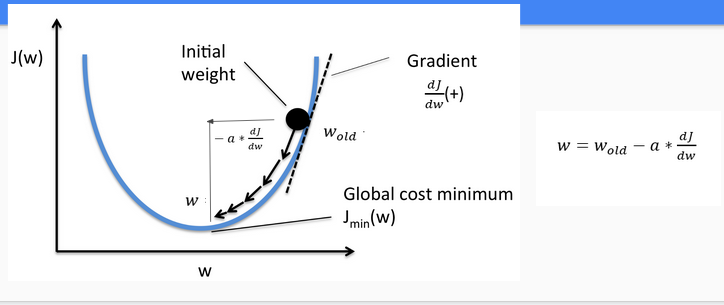

do is the partial derivative of error in regard to that layer's bias
e.g do_out = 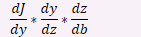


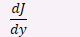 = -2(Ytrue-Yout)


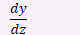= derivative of activation function, in this case the sigmoid, same as df(z_out)/dz_out


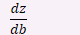=1 (as z= z_j*w+b)

We pretty much continue to do this down the line by using chain rule to get the gradient descent value of each params (delta_w, and delta_bias, which respectively corresponds to dJ/dw and dJ/db).
In order to update the params we use the gradient descent formula by multiplying dJ/dw or dJ/db with the learning rate and substracting it.

We first do the forward pass, and then after n(batch size) instances we calculate the backprop and update the values+reinitializing the values.

PS. I didnt multiply the error func's derivative by 2 for simplicity's sake, it's pretty much the same as multiplying alpha by 2 anyways so you could always tune it.


In [ ]:
#create weight change variables

do_i=np.zeros((1,layer_neurons))
do_j=np.zeros((1,layer_neurons))
do_out=np.zeros((1,output_neurons))
delta_wi=np.zeros((columns_train, layer_neurons))
delta_wj=np.zeros((layer_neurons, layer_neurons))
delta_wout=np.zeros((layer_neurons, 1))

delta_biasi=np.zeros((1, layer_neurons))
delta_biasj=np.zeros((1, layer_neurons))
delta_biasout=np.zeros((1, output_neurons))

#create old weight change variables for momentum
delta_wi_old=np.zeros((columns_train, layer_neurons))
delta_wj_old=np.zeros((layer_neurons, layer_neurons))
delta_wout_old=np.zeros((layer_neurons, 1))



In [ ]:
f_zi=np.zeros((1,layer_neurons))
f_zj=np.zeros((1,layer_neurons))
f_zout=np.zeros((1,output_neurons))

train_error=np.zeros(max_epoch)

In [ ]:
print('xtrain:',xtrain[0,:])
print('wi',w_i)
print(np.matmul(xtrain[0,:],w_i))

In [ ]:
import math
import matplotlib.pyplot as plt
#activation functions:
#in this code i use sigmoid, you could use others though+you could also use different activation functions for
#the output layer and hidden layers, just remember to adjust the derivative accordingly and choose an activation
#function for the output layer that is non negative, in this case I force the output to be between 1 and 0 but
#for other cases you might want to pay more attention on the value range of the activation function
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))
epoch=0
error=0
epocherror=0
count=1

while epoch<max_epoch:
#in this example i dont declare the input neurons explicitly, i use it in the for loop instead (inputx)
    for idx in range(rows_train):
        inputx=xtrain[idx,:].reshape(1,columns_train)
        inputy=ytrain[idx,:].reshape(1,output_neurons)
        
        #Input layer to first layer
        Z_i=np.matmul(inputx,w_i)+bias_i
        for index in range(layer_neurons):
            f_zi[0,index]=sigmoid(Z_i[0,index])
            
        #First layer to second layer
        Z_j=np.matmul(f_zi,w_j)+bias_j
        for index in range(layer_neurons):
            f_zj[0,index]=sigmoid(Z_j[0,index])
            
        #Second layer to output
        Z_out=np.matmul(f_zj,w_out)+bias_out
        
        #Rounding output values to one
        for index in range(output_neurons):
            f_zout[0,index]=sigmoid(Z_out[0,index])
            #output rounding
            #if f_zout[0,index]>=(1-treshold):
            #    f_zout[0,index]=1
            #elif f_zout[0,index]<=treshold:
            #    f_zout[0,index]=0   
        y=f_zout
        #np.zeros((1,output_neurons))#declare a 1D zero vector to store output value 
        #y[0,np.argmax(f_zout,axis=1)]=1#find the first true (1) value, assign 1 to the index, leaving other columns as zero
        
        epocherror=epocherror+sum((inputy-y)**2)
        
        for index in range(output_neurons):
            do_out[0,index]=-(inputy[0,index]-y[0,index])*dsigmoid(Z_out[0,index])
        #print(Z_out)
        delta_wout+=alpha*f_zj.T*do_out

        delta_biasout+=alpha*do_out
        
        for index in range(layer_neurons):
            do_j[0,index]=np.matmul(do_out,w_out.T)[0,index]*dsigmoid(Z_j[0,index])
            
        delta_wj+=alpha*f_zi.T*do_j
        delta_biasj+=alpha*do_j
        
        for index in range(layer_neurons):
            do_i[0,index]=np.matmul(do_j,w_j.T)[0,index]*dsigmoid(Z_i[0,index])
        
        delta_wi+=alpha*inputx.T*do_i
        delta_biasi+=alpha*do_i
        
        epochbatch=epoch%batch
        if epochbatch==0 or epoch==max_epoch-1:
            delta_wout/=batch
            w_out-=(delta_wout+delta_wout_old*mu)
            delta_wout_old=delta_wout
            delta_biasout/=batch
            bias_out==delta_biasout
            
            delta_wj/=batch
            w_j-=delta_wj+delta_wj_old*mu
            delta_wj_old=delta_wj
            delta_biasj/=batch
            bias_j-=delta_biasj
            
            delta_wi/=batch
            w_i-=delta_wi+delta_wi_old*mu
            delta_wi_old=delta_wi
            delta_biasi/=batch
            bias_i-=delta_biasi
            
            delta_wi=np.zeros((columns_train, layer_neurons))
            delta_wj=np.zeros((layer_neurons, layer_neurons))
            delta_wout=np.zeros((layer_neurons, 1))

            delta_biasi=np.zeros((1, layer_neurons))
            delta_biasj=np.zeros((1, layer_neurons))
            delta_biasout=np.zeros((1, output_neurons))
            
            
    train_error[epoch]=epocherror
    epocherror=0  
    epoch+=1
plt.plot(range(max_epoch),train_error)  
print(train_error)
        
            
        
        

**Result**
Below we try to test the ANN that we've built+trained. It's not the most accurate as this is a very simple ANN but good enough.

In [ ]:
from sklearn.metrics import classification_report
correct=0
y_pred=np.zeros((rows_test,1))
for idx in range(rows_test):
        inputx=xtest[idx,:].reshape(1,columns_test)
        inputy=ytest[idx,:].reshape(1,output_neurons)
        
        #Input layer to first layer
        Z_i=np.matmul(inputx,w_i)+bias_i
        for index in range(layer_neurons):
            f_zi[0,index]=sigmoid(Z_i[0,index])
            
        #First layer to second layer
        Z_j=np.matmul(f_zi,w_j)+bias_j
        for index in range(layer_neurons):
            f_zj[0,index]=sigmoid(Z_j[0,index])
            
        #Second layer to output
        Z_out=np.matmul(f_zj,w_out)+bias_out
        
        #Rounding output values to one
        for index in range(output_neurons):
            f_zout[0,index]=sigmoid(Z_out[0,index])

        epocherror=epocherror+sum((inputy-y)**2)
            #output rounding
        if f_zout[0,index]>=(1-treshold):
            f_zout[0,index]=1
        else:
            f_zout[0,index]=0

        y_pred[idx]=f_zout
        
        if f_zout == inputy:
            correct+=1
        #np.zeros((1,output_neurons))#declare a 1D zero vector to store output value 
        #y[0,np.argmax(f_zout,axis=1)]=1#find the first true (1) value, assign 1 to the index, leaving other columns as zero
        
print(classification_report(ytest,y_pred))
print(correct/rows_test)

In [ ]:
y_pred=np.zeros((datainputtest.shape[0]),int)
for idx in range(datainputtest.shape[0]):
        inputx=datainputtest[idx,:].reshape(1,datainputtest.shape[1])
        
        #Input layer to first layer
        Z_i=np.matmul(inputx,w_i)+bias_i
        for index in range(layer_neurons):
            f_zi[0,index]=sigmoid(Z_i[0,index])
            
        #First layer to second layer
        Z_j=np.matmul(f_zi,w_j)+bias_j
        for index in range(layer_neurons):
            f_zj[0,index]=sigmoid(Z_j[0,index])
            
        #Second layer to output
        Z_out=np.matmul(f_zj,w_out)+bias_out
        
        #Rounding output values to one
        for index in range(output_neurons):
            f_zout[0,index]=sigmoid(Z_out[0,index])

            #output rounding
        if f_zout[0,index]>=(1-treshold):
            f_zout[0,index]=1
        else:
            f_zout[0,index]=0

        y_pred[idx]=f_zout[0]

In [ ]:
result=pd.DataFrame({'PassengerId':testid,'Survived':y_pred})
result.to_csv("Res.csv",index=False)
print(result)

**Outro**


Hi guys, thanks for reading this notebook. I know this is not the clearest/efficient way of writing MLP but I hope this still helps those of you who want to learn the basics of it. Here are several suggestions on what to do with this notebook:

* Play with the params, initialization method, normalization, activation function etc  (mu, learning rate, batch size, Z-score, min-max, ReLu, linear, num of layers, neurons) all will affect the performance of the ANN, tinkering with those a little bit will help you understand the effect of those changes
* Vectorize! This code is not the best way to implement MLP, as you can see I still use a lot of for loops instead of using matrix multiplication using numpy. Try to get rid of the for loops and replace it with vector multiplication instead.
* Try implementing learning rate decay or optimization algorithms such as adam/ other momentum formulas
* Try it on other datasets

Thanks!